# Hand Detection

Computer Vision project 

Packages required

In [1]:
import os
import cv2
import scipy.io
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import tensorflow
from tensorflow import keras

#mat files
!pip install mat4py
from mat4py import loadmat

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Download Dataset

The dataset (https://www.robots.ox.ac.uk/~vgg/data/hands/) wiil be placed in the *dataset* folder and it has the following structure:

dataset
- training_dataset
  * training_data
    - annotations
    - images
- test_dataset
  * test_data
    - annotations
    - images
- validation_dataset
  * validation_data
    - annotations
    - images


In [2]:
from google.colab import drive
drive.mount('/content/drive')

#create folder
!mkdir /content/dataset

#unzip into new folder folder
!tar -xzvf '/content/drive/MyDrive/hand_dataset.tar.gz' -C '/content/dataset'

Streaming output truncated to the last 5000 lines.
hand_dataset/training_dataset/training_data/images/Inria_11.jpg
hand_dataset/training_dataset/training_data/images/Inria_110.jpg
hand_dataset/training_dataset/training_data/images/Inria_111.jpg
hand_dataset/training_dataset/training_data/images/Inria_112.jpg
hand_dataset/training_dataset/training_data/images/Inria_113.jpg
hand_dataset/training_dataset/training_data/images/Inria_114.jpg
hand_dataset/training_dataset/training_data/images/Inria_115.jpg
hand_dataset/training_dataset/training_data/images/Inria_116.jpg
hand_dataset/training_dataset/training_data/images/Inria_117.jpg
hand_dataset/training_dataset/training_data/images/Inria_118.jpg
hand_dataset/training_dataset/training_data/images/Inria_119.jpg
hand_dataset/training_dataset/training_data/images/Inria_12.jpg
hand_dataset/training_dataset/training_data/images/Inria_120.jpg
hand_dataset/training_dataset/training_data/images/Inria_121.jpg
hand_dataset/training_dataset/training_da

### Import Dataset
Import the three Train, Test and Validation dataset

In [3]:
#function to load a dataset from its directory
def load_dataset(path):
  data = []
  images_path = os.path.join(path, 'images')
  annotations_path = os.path.join(path, 'annotations')

  for img_name in os.listdir(images_path):
    ann_name = img_name[:-3] + 'mat'
    try:
      #get image
      img = cv2.imread(os.path.join(images_path, img_name))
      #convert to rgb
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      #TODO: resize image (?)

      #get annotations and convert it
      boxes = loadmat(os.path.join(annotations_path, ann_name))['boxes']
      if type(boxes) == list:
        annotations = [list(box.values())[:4] for box in boxes]
      elif type(boxes) == dict:
        annotations = list(boxes.values())
      data.append([img, annotations])
    except Exception as e:
      print(e)
  return np.array(data)


#path of the datasets
data_dir = Path('/content/dataset/hand_dataset')
train_dir = os.path.join(data_dir, 'training_dataset/training_data')
val_dir = os.path.join(data_dir, 'validation_dataset/validation_data')
test_dir = os.path.join(data_dir, 'test_dataset/test_data')

train_dataset = load_dataset(train_dir)
val_dataset = load_dataset(val_dir)
test_dataset = load_dataset(test_dir)

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


OpenCV(4.1.2) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'



Visualize a sample and its annoatations

In [4]:
print('Number of annotations: ', len(train_dataset[0][1]))
print(train_dataset[0][1])

Number of annotations:  4
[[432.4696414195462, 255.7352770848963], [410.2503585804542, 272.9047229151038], [445.61035858045415, 318.66472291510377], [467.8296414195462, 301.4952770848963]]


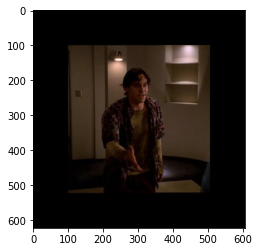

In [5]:
plt.imshow(train_dataset[0][0])

In [25]:
def draw_boxes(img, boxes):
  image = img.copy()
  color = (0, 255, 0)
  for box in boxes:
    #upper left corner
    start_point = (int(box[1][1]), int(box[1][0]))
    #bottom right corner
    end_point = (int(box[3][1]), int(box[3][0]))
    image = cv2.rectangle(img, start_point, end_point, color, 5)

  plt.imshow(image)

In [26]:
draw_boxes(train_dataset[40][0], train_dataset[40][1])

TypeError: ignored

**Dataset Structure**

    dataset[0] = image and annotations
    dataset[0][0] = image
    dataset[0][1] = annotations

In [46]:
# Create masked dataset for the neural network
def create_mask(dataset):
  masked_dataset = []
  for element in dataset:
    image = element[0]
    annotation = element[1]
    color = (0, 255, 0)
    for box in annotation:
      #upper left corner
      start_point = (int(box[1][1]), int(box[1][0]))
      #bottom right corner
      end_point = (int(box[3][1]), int(box[3][0]))
      newimage = np.zeros(image.shape)
      # set element inside bounding box to 255
      newimage[start_point[0]:end_point[0],start_point[1]:end_point[1],:] = 255    
    masked_dataset.append(newimage)
  return np.array(masked_dataset)


In [47]:
masked = create_mask(train_dataset)

TypeError: ignored